In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from mat4py import loadmat
from scipy.linalg import block_diag

## simulate ESM model

### parameters

In [7]:
data = loadmat('PANmodel.mat')
data['model'].keys()

dict_keys(['OCV0', 'OCVrel', 'SOC', 'OCV', 'SOC0', 'SOCrel', 'OCVeta', 'OCVQ', 'name', 'temps', 'etaParam', 'QParam', 'GParam', 'M0Param', 'MParam', 'R0Param', 'RCParam', 'RParam', 'dOCV0', 'dOCVrel'])

In [8]:
name = data['model']['name']
temps = data['model']['temps']
etaParam = data['model']['etaParam'][temps.index(25)]
QParam = data['model']['QParam'][temps.index(25)]
GParam = data['model']['GParam'][temps.index(25)]
M0Param = data['model']['M0Param'][temps.index(25)]
MParam = data['model']['MParam'][temps.index(25)]
R0Param = data['model']['R0Param'][temps.index(25)]
RCParam = np.array(data['model']['RCParam'][temps.index(25)])
RParam = np.array(data['model']['RParam'][temps.index(25)])

In [6]:
# ???

# G = getParamESC('GParam',T,model);
# Q = getParamESC('QParam',T,model);
# M = getParamESC('MParam',T,model);
# M0 = getParamESC('M0Param',T,model);
# RParam = getParamESC('RParam',T,model);
# R0Param = getParamESC('R0Param',T,model);
# etaParam = getParamESC('etaParam',T,model);

### dynamic

In [ ]:
# states
etaik = ik; etaik(ik<0) = etaParam*ik(ik<0)

% Simulate the dynamic states of the model
rck = zeros(length(RCfact),length(etaik)); rck(:,1) = iR0
for k = 2:length(ik),
    rck(:,k) = diag(RCfact)*rck(:,k-1) + (1-RCfact)*etaik(k-1)
end
rck = rck'
zk = z0-cumsum([0;etaik(1:end-1)])*deltaT/(Q*3600)
if any(zk>1.1),
    warning('Current may have wrong sign as SOC > 110%')
end
  
% Hysteresis stuff
hk=zeros([length(ik) 1]); hk(1) = h0; sik = 0*hk
fac=exp(-abs(G*etaik*deltaT/(3600*Q)))
for k=2:length(ik),
    hk(k)=fac(k-1)*hk(k-1)-(1-fac(k-1))*sign(ik(k-1))
    sik(k) = sign(ik(k));
    if abs(ik(k))<Q/100, sik(k) = sik(k-1); end
end
    
% Compute output equation
OCV = OCVfromSOCtemp(zk,T,model);


% Calculate new states for all of the old state vectors in xold.  
function xnew = stateEqn(xold,current,xnoise)
    current = current + xnoise; % noise adds to current
    xnew = 0*xold;
    xnew(irInd,:) = diag(RC)*xold(irInd,:) + (1-diag(RC))*current;
    Ah = exp(-abs(current*G*deltat/(3600*Q)));  % hysteresis factor
    xnew(hkInd,:) = Ah.*xold(hkInd,:) + (Ah-1).*sign(current);
    xnew(zkInd,:) = xold(zkInd,:) - current/3600/Q;
    xnew(hkInd,:) = min(1,max(-1,xnew(hkInd,:)));        np.clip(-1.5, -1,1)
    xnew(zkInd,:) = min(1.05,max(-0.05,xnew(zkInd,:)));  np.clip(-1.5, -0.05,1.05)
end

self.sik = 0

eta=etaParam if current<0 else 1

Ah = np.exp(-abs(eta*current*GParam*dt/(3600*QParam)))  # hysteresis factor
Arc = np.diag(np.exp(-dt/abs(RCParam)))
Brc = 1-(np.exp(-dt/abs(RCParam)))

z_k1 = z_k - (eta*dt/(3600*QParam))*current
iR_k1 = Arc@iR_k + Brc*current
h_k1 = Ah@h_k + (1-Ah)*np.sign(current)

z_k1 = np.clip(z_k1, -0.05, 1.05)
h_k1 = np.clip(h_k1, -1, 1)

if abs(current)>QParam/100: self.sik = sign(current)


# output
voltage = OCV + MParam*h_k1 + M0Param*self.sik - RParam*iR_k - R0Param*current

function yhat = outputEqn(xhat,current,ynoise,T,model)
    yhat = OCVfromSOCtemp(xhat(zkInd,:),T,model) + M*xhat(hkInd,:) + M0*signIk - R*xhat(irInd,:) - R0*current + ynoise(1,:);
end

### OCV ftom SOC

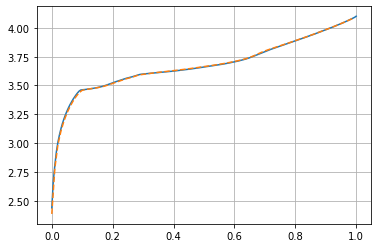

In [16]:
def make_OCVfromSOCtemp(data, T):
    SOC = np.array(data['model']['SOC'])
    OCV0 = np.array(data['model']['OCV0'])
    OCVrel = np.array(data['model']['OCVrel'])
    OCV = OCV0 + T*OCVrel
    OCVfromSOC = interpolate.interp1d(SOC, OCV, fill_value="extrapolate")
    return OCVfromSOC

OCVfromSOC = make_OCVfromSOCtemp(data, 25)
xnew = np.arange(0,1,0.01)
ynew = OCVfromSOC(xnew)

plt.plot(data['model']['SOC'],data['model']['OCV0'])
plt.plot(xnew,ynew,linestyle='--')
plt.grid()


### dOCV ftom SOC

In [ ]:
def make_dOCVfromSOCtemp(data, T):
    SOC = np.array(data['model']['SOC'])
    OCV0 = np.array(data['model']['OCV0'])
    OCVrel = np.array(data['model']['OCVrel'])
    OCV = OCV0 + T*OCVrel

    dZ = SOC[1] - SOC[0]
    dUdZ = np.diff(OCV)/dZ
    dOCV = (np.append(dUdZ[0],dUdZ) + np.append(dUdZ,dUdZ[-1]))/2
    dOCVfromSOC = interpolate.interp1d(SOC, dOCV, fill_value="extrapolate")
    return dOCVfromSOC

dOCVfromSOC = make_dOCVfromSOCtemp(data, 25)
xnew = np.arange(0,1,0.01)
ynew = dOCVfromSOC(xnew)

plt.plot(xnew,ynew)
plt.grid()
plt.ylim([0,5])

### LIB class

In [29]:
class LithiumIonBattery():
    def __init__(self, model_path, T, dt):
        data = loadmat(model_path)
        self.name = data['model']['name']
        self.temps = data['model']['temps']
        self.etaParam = data['model']['etaParam'][self.temps.index(T)]
        self.QParam = data['model']['QParam'][self.temps.index(T)]
        self.GParam = data['model']['GParam'][self.temps.index(T)]
        self.M0Param = data['model']['M0Param'][self.temps.index(T)]
        self.MParam = data['model']['MParam'][self.temps.index(T)]
        self.R0Param = data['model']['R0Param'][self.temps.index(T)]
        self.RCParam = np.array(data['model']['RCParam'][self.temps.index(T)])
        self.RParam = np.array(data['model']['RParam'][self.temps.index(T)])

        self.OCVfromSOC = make_OCVfromSOCtemp(data, T)

        self.sik = 0
        self.dt = dt
        self.z_k = 1
        self.iR_k = np.zeros((1,1))
        self.h_k = 0
        
    def update_state(self, current):
        eta=self.etaParam if current<0 else 1
        Ah = np.exp(-abs(eta*current*self.GParam*self.dt/(3600*self.QParam)))  # hysteresis factor
        Arc = np.diag(np.exp(-self.dt/abs(self.RCParam)))
        Brc = 1-(np.exp(-self.dt/abs(self.RCParam)))

        z_k1 = self.z_k - (eta*self.dt/(3600*self.QParam))*current
        iR_k1 = Arc@self.iR_k + Brc*current
        h_k1 = Ah*self.h_k - (1-Ah)*np.sign(current)

        z_k1 = np.clip(z_k1, -0.05, 1.05)
        h_k1 = np.clip(h_k1, -1, 1)

        if abs(current)>self.QParam/100: self.sik = np.sign(current)
        voltage = self.OCVfromSOC(self.z_k) + self.MParam*self.h_k + self.M0Param*self.sik - self.RParam*self.iR_k - self.R0Param*current

        self.z_k = z_k1
        self.iR_k = iR_k1
        self.h_k = h_k1

        return voltage.item()

In [30]:
LIB1 = LithiumIonBattery('PANmodel.mat', 25, 1)

In [31]:
v= LIB1.update_state(1000)
print(LIB1.z_k, LIB1.iR_k, LIB1.h_k,v)

0.9888352484434476 [[239.2390634]] -0.8387472006219658 2.962826566792851


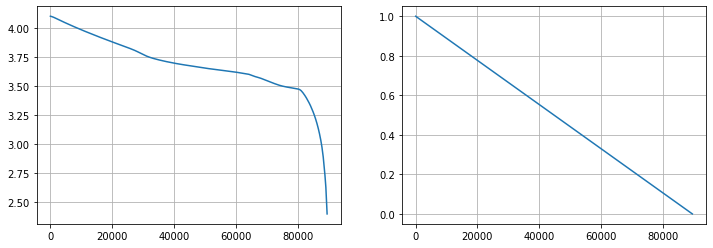

In [74]:
Z = []
V = []
while LIB1.z_k >=0:
    v = LIB1.update_state(1)
    Z.append(LIB1.z_k)
    V.append(v)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(Z)),V)
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.arange(len(Z)),Z)
plt.grid()

In [49]:
deltat = 1
current = 1
Ah = np.exp(-abs(etaParam*current*GParam*deltat/(3600*QParam)))  # hysteresis factor
Arc = np.diag(np.exp(-deltat/abs(RCParam)))
A = block_diag(1,Ah,Arc)
A

array([[1.        , 0.        , 0.        ],
       [0.        , 0.99817917, 0.        ],
       [0.        , 0.        , 0.76076094]])

In [70]:
Brc = 1-(np.exp(-deltat/abs(RCParam)))
B = np.block([[-(etaParam*deltat/(3600*QParam)), 0],[Brc, np.zeros((len(Brc),1))],[0, Ah-1]])
B


array([[-1.11507145e-05,  0.00000000e+00],
       [ 2.39239063e-01,  0.00000000e+00],
       [ 0.00000000e+00, -1.82082800e-03]])

In [75]:
u = np.array([[current, np.sign(current)]]).T
u

array([[1],
       [1]])

# plot SoC

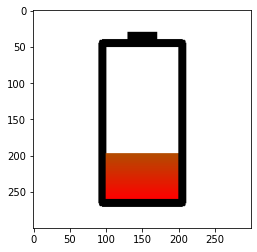

In [75]:
def plot_SOC(SOC):
    img = np.ones((300,300,3), dtype='uint8')*255
    img = cv2.rectangle(img, (95,45), (205,265), 0, 10) # H: 50-260 / W: 100-200
    img = cv2.rectangle(img, (130,30), (170,45), 0, -1)
    soc = np.array(range(0,SOC+1))
    soc = np.append(0,soc)
    green = (soc*255/100).astype(int)
    red = 255-green
    y = (-210/100*soc + 260).astype(int)
    for i in range(1,len(soc)): img[y[i]:y[i-1],100:200] = [0,green[i],red[i]] 
    return img


plt.imshow(plot_SOC(30)[...,::-1])
# cv2.imwrite('out1.jpg',plot_SOC(0))